In [1]:
from google.colab import files
uloaded = files.upload()

Saving spam_ham_dataset.csv to spam_ham_dataset.csv


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
# load data
dataset = pd.read_csv('spam_ham_dataset.csv')
dataset.head(10)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
5,2949,ham,Subject: ehronline web address change\r\nthis ...,0
6,2793,ham,Subject: spring savings certificate - take 30 ...,0
7,4185,spam,Subject: looking for medication ? we ` re the ...,1
8,2641,ham,Subject: noms / actual flow for 2 / 26\r\nwe a...,0
9,1870,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0


In [4]:
data = dataset.copy()  # copying data

In [5]:
# shape of data
data.shape

(5171, 4)

In [6]:
# target vvalue count
data.label_num.value_counts()

0    3672
1    1499
Name: label_num, dtype: int64

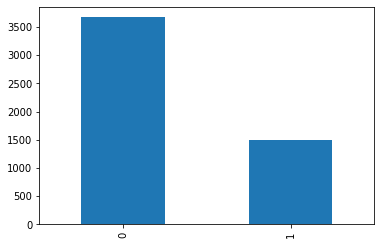

In [53]:
data.label_num.value_counts().plot(kind='bar')

In [7]:
data.isna().sum() # checking for nan values

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

#### 2. Preprocessing
Here we shall do these tasks:
<ul>
<li>remove unwnated and special characters, numbers, symbols, punctuations, etc.</li>
<li>Remove short words(most of the time shortwords<3 doesnot convey special meanings)</li>
<li>Remove stop words</li>
<li> Perform lemmatization and stemming</li>
</ul>


In [8]:
# we will drop all columns except text and label_num
data = data.drop('label',axis=1)
data = data.drop('Unnamed: 0',axis=1)
data.head(10)

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0
5,Subject: ehronline web address change\r\nthis ...,0
6,Subject: spring savings certificate - take 30 ...,0
7,Subject: looking for medication ? we ` re the ...,1
8,Subject: noms / actual flow for 2 / 26\r\nwe a...,0
9,"Subject: nominations for oct . 21 - 23 , 2000\...",0


In [9]:
# remove special characters, numbers, punctuations
data['cleaned_text'] = data['text'].str.replace("[^a-zA-Z#]", " ")

In [10]:
data.head()

,text,label_num,cleaned_text
0,Subject: enron methanol ; meter # : 988291\r\n...,0,Subject enron methanol meter # th...
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,Subject hpl nom for january see a...
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,Subject neon retreat ho ho ho we re arou...
3,"Subject: photoshop , windows , office . cheap ...",1,Subject photoshop windows office cheap ...
4,Subject: re : indian springs\r\nthis deal is t...,0,Subject re indian springs this deal is to ...


In [11]:
data['cleaned_text'][0] # checking to see if above preprocessing did it's task or not

'Subject  enron methanol   meter #           this is a follow up to the note i gave you on monday                preliminary  flow data provided by daren      please override pop   s daily volume   presently zero   to reflect daily  activity you can obtain from gas control    this change is needed asap for economics purposes  '

We can see exept for # all characters,numbers , punctuations are removed.  

Removing short words. shorts words most of the time don't convey any special info tough some times its exceptions

In [14]:
# reomive all words whose length are less than 3
data['cleaned_text'] = data['cleaned_text'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>3]))

In [16]:
# tokenize the words 
from nltk.tokenize import word_tokenize
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: word_tokenize(x))
data.cleaned_text.head()

0    [Subject, enron, methanol, meter, this, follow...
1    [Subject, january, attached, file, hplnol, hpl...
2    [Subject, neon, retreat, around, that, most, w...
3    [Subject, photoshop, windows, office, cheap, m...
4    [Subject, indian, springs, this, deal, book, t...
Name: cleaned_text, dtype: object

In [17]:
# lets view first text value of cleaned text to see word tokens
print(data.cleaned_text[0])

['Subject', 'enron', 'methanol', 'meter', 'this', 'follow', 'note', 'gave', 'monday', 'preliminary', 'flow', 'data', 'provided', 'daren', 'please', 'override', 'daily', 'volume', 'presently', 'zero', 'reflect', 'daily', 'activity', 'obtain', 'from', 'control', 'this', 'change', 'needed', 'asap', 'economics', 'purposes']


In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# removing stopwords
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: [w for w in x if w not in stopwords.words('english')])
data.cleaned_text[0]

['Subject',
 'enron',
 'methanol',
 'meter',
 'follow',
 'note',
 'gave',
 'monday',
 'preliminary',
 'flow',
 'data',
 'provided',
 'daren',
 'please',
 'override',
 'daily',
 'volume',
 'presently',
 'zero',
 'reflect',
 'daily',
 'activity',
 'obtain',
 'control',
 'change',
 'needed',
 'asap',
 'economics',
 'purposes']

In [20]:
# stemming
stemmer = PorterStemmer()
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: [stemmer.stem(i) for i in x])
print(data.cleaned_text[0])

['subject', 'enron', 'methanol', 'meter', 'follow', 'note', 'gave', 'monday', 'preliminari', 'flow', 'data', 'provid', 'daren', 'pleas', 'overrid', 'daili', 'volum', 'present', 'zero', 'reflect', 'daili', 'activ', 'obtain', 'control', 'chang', 'need', 'asap', 'econom', 'purpos']


In [21]:
data.head(10)

,text,label_num,cleaned_text
0,Subject: enron methanol ; meter # : 988291\r\n...,0,"[subject, enron, methanol, meter, follow, note..."
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"[subject, januari, attach, file, hplnol, hplnol]"
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"[subject, neon, retreat, around, wonder, time,..."
3,"Subject: photoshop , windows , office . cheap ...",1,"[subject, photoshop, window, offic, cheap, mai..."
4,Subject: re : indian springs\r\nthis deal is t...,0,"[subject, indian, spring, deal, book, teco, re..."
5,Subject: ehronline web address change\r\nthis ...,0,"[subject, ehronlin, address, chang, messag, in..."
6,Subject: spring savings certificate - take 30 ...,0,"[subject, spring, save, certif, take, save, cu..."
7,Subject: looking for medication ? we ` re the ...,1,"[subject, look, medic, best, sourc, difficult,..."
8,Subject: noms / actual flow for 2 / 26\r\nwe a...,0,"[subject, nom, actual, flow, agre, forward, me..."
9,"Subject: nominations for oct . 21 - 23 , 2000\...",0,"[subject, nomin, attach, file, hplnl, hplnl]"


In [22]:
# lets join the tokenized words
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: ' '.join(w for w in x))
data.head(10)

,text,label_num,cleaned_text
0,Subject: enron methanol ; meter # : 988291\r\n...,0,subject enron methanol meter follow note gave ...
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,subject januari attach file hplnol hplnol
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,subject neon retreat around wonder time year n...
3,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop window offic cheap main tren...
4,Subject: re : indian springs\r\nthis deal is t...,0,subject indian spring deal book teco revenu un...
5,Subject: ehronline web address change\r\nthis ...,0,subject ehronlin address chang messag intend e...
6,Subject: spring savings certificate - take 30 ...,0,subject spring save certif take save custom ap...
7,Subject: looking for medication ? we ` re the ...,1,subject look medic best sourc difficult make m...
8,Subject: noms / actual flow for 2 / 26\r\nwe a...,0,subject nom actual flow agre forward melissa j...
9,"Subject: nominations for oct . 21 - 23 , 2000\...",0,subject nomin attach file hplnl hplnl


In [23]:
data.cleaned_text[0]

'subject enron methanol meter follow note gave monday preliminari flow data provid daren pleas overrid daili volum present zero reflect daili activ obtain control chang need asap econom purpos'

#### Model Building

In [24]:
# applying countVectorizer / creating bag-of-word model
# below module is already imported above but lets do it again for simplification
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=4000,ngram_range=(1,3))
X = cv.fit_transform(data['cleaned_text']).toarray()

In [25]:
X.shape

(5171, 4000)

In [26]:
y = data['label_num']
print(y.shape)
y.head()

(5171,)


0    0
1    0
2    0
3    1
4    0
Name: label_num, dtype: int64

In [27]:
# split data into traina nd test vectors
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.3, random_state=0)

In [28]:
xtrain.shape,ytrain.shape

((3619, 4000), (3619,))

In [29]:
xtest.shape, ytest.shape

((1552, 4000), (1552,))

In [30]:
# create bag_of_word dataframe
bow_df = pd.DataFrame(xtrain, columns=cv.get_feature_names())

In [31]:
bow_df.head()

,abdv,abil,abl,absenc,absolut,accept,access,accessori,accomplish,accord,accordingli,account,account arrang,accur,accuraci,achiev,acquir,acquisit,across,act,action,action could,action could might,action identifi,action identifi word,activ,activ alloc,activ alloc except,activ meter,acton,acton corp,acton corp enron,actual,actual august,actual flow,actual flow agre,actual juli,actual june,actual novemb,actual octob,...,would appreci,would like,would like remov,would need,would pleas,write,write volum,write volum unaccount,writeoff,writeoff volum,writeoff volum unaccount,written,wrong,wynn,wynn howard,wynn howard camp,wynn rita,wynn subject,wysak,xanax,yahoo,year,yesterday,york,young,young daren,young daren farmer,young subject,yvett,yvett connevey,yvett connevey corp,zajac,zero,zivley,zone,zone computron,zone computron price,zonedubai,zonedubai computron,zonedubai computron latest
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# Function to train  classifier

def train_classifier(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    prediction = model.predict(test_data)
    acc = round(accuracy_score(prediction, test_labels)*100, 0)
    
    print(f'ACCURACY = {acc} %')
    return acc, model

# Creating dictionary to record accuracy of each model
accuracies = {}

##### 3.1 MultinomialNB

In [42]:
classifier = MultinomialNB()
accuracies['Naive Bayes'], nb = train_classifier(classifier, xtrain, ytrain, xtest, ytest)

ACCURACY = 96.0 %


##### 3.2 Logistic Regression

In [44]:
classifier = LogisticRegression(multi_class='multinomial', solver='sag')
accuracies['Logistic Regression'], logreg = train_classifier(classifier, xtrain, ytrain, xtest, ytest)

ACCURACY = 95.0 %


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


##### 3.3 Random Forest

In [45]:
classifier = RandomForestClassifier(n_estimators = 500, min_samples_split = 10, random_state = 42)
accuracies['Random Forest'], ranfor = train_classifier(classifier, xtrain, ytrain, xtest, ytest)

ACCURACY = 96.0 %


#### 3.4 Support Vector Machine

In [46]:
classifier = SVC(C = 2.5, kernel = 'linear', gamma='auto', random_state=42)
accuracies['Linear SVM'], svm = train_classifier(classifier, xtrain, ytrain, xtest, ytest)

ACCURACY = 95.0 %


Accuracy scores from above different models are similiar so we will only make classification report for only one of them. Here i choosed Random Forest.

In [48]:
ypred = ranfor.predict(xtest)
print("\nSVM Classifier results: \n")
print(classification_report(ytest, ypred))


SVM Classifier results: 

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1128
           1       0.93      0.95      0.94       424

    accuracy                           0.96      1552
   macro avg       0.95      0.96      0.96      1552
weighted avg       0.96      0.96      0.96      1552



In [50]:
!pip install mlxtend

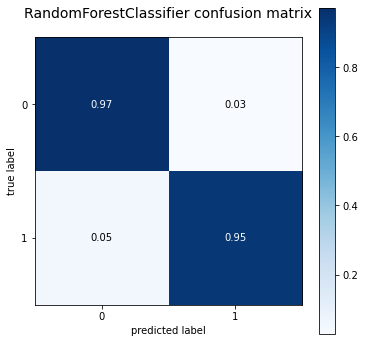

In [52]:
# CONFUSION MATRIX
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = confusion_matrix(ytest, ypred),
                                colorbar = True,
                                show_absolute = False,
                                show_normed = True,
                                figsize = (6,6))
plt.title("RandomForestClassifier confusion matrix", fontsize=14)
plt.show()